# Model Description

For $n=1,...,N$,
\begin{align}
Z_n &\sim N(0,I_d)\\ 
Y_{n,k} &\sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n^T \beta_k - \beta_{k,0})}\right)
\end{align}.
This model carries out dimentionality reduction of binary observations $y_{n,k}$'s.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n;y_n)= N(z_n;A_0 + A y_n,\mathrm{diag}( \mathrm{softplus}(B_0 + B y_n)))$

## Why Renyi? -> Fast inference (Does not require fixed point iteration)

# Import Packages

In [63]:
import tensorflow as tf
import tensorflow_probability as tfp

In [64]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
from matplotlib import pyplot as plt

# Utilities

In [65]:
tf_float_type = tf.float64
np_float_type = np.float64
as_tf_float = lambda x: tf.cast(x, tf_float_type)

In [66]:
def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

In [67]:
sigmoid = lambda x:1/(1+np.exp(-x))

# Generate Toy Dataset

In [105]:
n = 10000
d = 1
k = 10

In [118]:
z  = np.random.randn(n*d).reshape([n,d])
z_ = np.concatenate([z,np.ones([n,1])], axis=1)
beta = np.random.randn(k*(d+1)).reshape([d+1,k])
beta[-1]=0
y = bernoulli(p=sigmoid(z_@beta)).rvs()

## Variatioal Bayes by KL[q||p]

In [119]:
def pointwise_ELBO(y, z, beta, A, B):
    """
    Compute ELBO for n_MC samples of beta, where the shape of beta is [n_MC, dim_x].
    
    Arguments:
    y: 2-d array of size [n, k]
    z: 2-d array of size [n, d]
    beta: 2-d array of size [d+1, k] 
    Theta_mean, Theta_var: 2-d array of size [k+1, d]
    
    Returns:
    elbo: elbo, whose size is [n]
    """
    n, d = z.shape
    z_ = tf.concat([z, tf.ones([n,1], dtype=tf_float_type)], axis=1)
    y_ = tf.concat([y, tf.ones([n,1], dtype=tf_float_type)], axis=1)
    
    p_y = tfp.distributions.Bernoulli(logits=tf.math.sigmoid(z_@beta))
    p_z = tfp.distributions.Normal(loc=np.zeros([n, d]), scale=np.ones([n, d]))
    q_z = tfp.distributions.Normal(loc=y_@A, scale=tf.math.softplus(y_@B))
    elbo = tf.reduce_sum( p_y.log_prob(y), axis=1)\
        + tf.reduce_sum(p_z.log_prob(z), axis=1)\
        - tf.reduce_sum(q_z.log_prob(z), axis=1)
    return elbo

In [120]:
def ELBO(y, beta, A, B):
    n, d = y.shape
    y_ = tf.concat([y, tf.ones([n,1], dtype=tf_float_type)], axis=1)
    q_z = tfp.distributions.Normal(loc=y_@A, scale=tf.math.softplus(y_@B))
    z = q_z.sample()
    elbo = tf.reduce_mean( pointwise_ELBO(y, z, beta, A, B) )
    return elbo

In [121]:
A = tf.Variable(np.zeros([k+1, d]))
B = tf.Variable(np.zeros([k+1, d]))
beta_ = tf.Variable(np.zeros([d+1, k])) 
    
for t in range(100):
    rho_t = 1.5/(10+t)**0.7
    
    with tf.GradientTape() as g:
        g.watch([A, B, beta_])
        score = ELBO(y, beta_, A, B)
    dA, dB, dbeta_ = g.gradient(score, [A, B, beta_])

    A = A + rho_t*dA
    B = B + rho_t*dB
    beta_ = beta_ + dbeta_
    if t%10==0:
        print(score)

tf.Tensor(-7.347140122917891, shape=(), dtype=float64)
tf.Tensor(-7.166115919205017, shape=(), dtype=float64)
tf.Tensor(-7.108480618686251, shape=(), dtype=float64)
tf.Tensor(-7.069074812501715, shape=(), dtype=float64)
tf.Tensor(-7.040747536822327, shape=(), dtype=float64)
tf.Tensor(-7.021609235771452, shape=(), dtype=float64)
tf.Tensor(-7.007019565887407, shape=(), dtype=float64)
tf.Tensor(-6.996164468448842, shape=(), dtype=float64)
tf.Tensor(-6.98784052215251, shape=(), dtype=float64)
tf.Tensor(-6.981341337966005, shape=(), dtype=float64)


In [122]:
y_ = tf.concat([y, tf.ones([n,1], dtype=tf_float_type)], axis=1)

In [123]:
beta_

<tf.Tensor: shape=(2, 10), dtype=float64, numpy=
array([[-5.72232851e-03, -5.03886046e-03, -1.41861022e-02,
         1.10092480e-03,  3.41613337e-03, -2.56629889e-03,
        -1.99576413e-03, -2.56769837e-03, -4.45294576e-03,
        -4.43395504e-03],
       [-1.54963192e+00, -1.48436406e+00, -1.54652008e+00,
        -1.44318472e+00, -1.51771987e+00, -1.39384479e+00,
        -1.50630467e+00, -1.51875442e+00, -1.52702663e+00,
        -1.50629802e+00]])>

In [112]:
beta

array([[ 1.84503716, -0.58053618, -0.77640745, -1.35393944, -1.0406653 ,
         0.37820293, -0.91373719,  0.76160462,  0.14653945,  1.11535518],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [113]:
y_@A

<tf.Tensor: shape=(10000, 1), dtype=float64, numpy=
array([[-1.17752264e-03],
       [-1.60777980e-03],
       [ 3.71723633e-04],
       ...,
       [-5.74998117e-04],
       [-3.18574246e-03],
       [-8.23457843e-05]])>

In [114]:
tf.math.softplus(y_@B)

<tf.Tensor: shape=(10000, 1), dtype=float64, numpy=
array([[1.02158727],
       [1.01594493],
       [0.96270775],
       ...,
       [1.0485849 ],
       [1.01477606],
       [0.87327838]])>

In [76]:
z

array([[ 0.0955569 ,  0.64059843],
       [ 0.3576199 , -0.10300578],
       [-0.69971399, -0.03910733],
       ...,
       [-0.59912762, -0.30518316],
       [-1.87704468,  0.44348144],
       [ 0.13548086, -1.55734755]])

## Variational Bayes by Renyi Divergence

In [77]:
def pointwise_IWELBO(y, z, beta, A, B):
    """
    Compute ELBO for n_MC samples of beta, where the shape of beta is [n_MC, dim_x].
    
    Arguments:
    loc_beta: 1-d array of size [dim_x]
    scale_beta: 1-d array of size [dim_x]
    beta: 3-d array of size [n_MC_out, n_MC_in, dim_x] representing the n_MC samples of beta taken from q_beta
    
    Returns:
    elbo: n_MC MC-samples of elbo
    """

    n_MC, n, d = z.shape
    z_ = tf.concat([z, tf.ones([n_MC, n,1], dtype=tf_float_type)], axis=2)
    y_ = tf.concat([y, tf.ones([n,1], dtype=tf_float_type)], axis=1)
    
    p_y = tfp.distributions.Bernoulli(logits=tf.math.sigmoid(z_@beta))
    p_z = tfp.distributions.Normal(loc=np.zeros([n, d]), scale=np.ones([n, d]))
    q_z = tfp.distributions.Normal(loc=y_@A, scale=tf.math.softplus(y_@B))
    log_prob_ratio = tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + tf.reduce_sum(p_z.log_prob(z), axis=2)\
        - tf.reduce_sum(q_z.log_prob(z), axis=2)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [78]:
def IWELBO(y, beta, A, B, n_MC=1):
    n, d = y.shape
    y_ = tf.concat([y, tf.ones([n,1], dtype=tf_float_type)], axis=1)
    q_z = tfp.distributions.Normal(loc=y_@A, scale=tf.math.softplus(y_@B))
    z = q_z.sample(n_MC)
    iwelbo = tf.reduce_mean( pointwise_IWELBO(y, z, beta, A, B) )
    return iwelbo

In [115]:
IWELBO(y, beta_, A, B, n_MC=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-6.9749455778699225>

In [116]:
ELBO(y, beta_, A, B)

<tf.Tensor: shape=(), dtype=float64, numpy=-6.976345133768971>

In [20]:
def pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma):
    """
    Compute ELBO for n_MC samples of beta, where the shape of beta is [n_MC, dim_x].
    
    Arguments:
    loc_beta: 1-d array of size [dim_x]
    scale_beta: 1-d array of size [dim_x]
    beta: 3-d array of size [n_MC_out, n_MC_in, dim_x] representing the n_MC samples of beta taken from q_beta
    
    Returns:
    elbo: n_MC MC-samples of elbo
    """

    p_beta = tfp.distributions.Normal(loc=np.zeros([dim_x]), scale=np.ones([dim_x]))
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    z = beta @ x.T# of shape [n_MC_out, n_MC_in, n_train]
    p_y = tfp.distributions.Bernoulli(logits=z)
    log_prob_ratio = tf.reduce_sum( p_y.log_prob(y), axis=2)\
                    + tf.reduce_sum( p_beta.log_prob(beta), axis=2)\
                    - tf.reduce_sum( q_beta.log_prob(beta), axis=2)# of shape [n_MC_out, n_MC_in]
    score = 1./gamma * tf_logmeanexp(gamma * log_prob_ratio, axis=1)
    return score

In [21]:
def Renyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=1, n_MC_in=1):
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample([n_MC_out, n_MC_in])# of shape [n_MC_out, n_MC_in, dim_x]
    score = tf.reduce_mean( pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma) )
    return score

In [22]:
Renyi_Chi(loc, scale, gamma=1, n_MC_out=100, n_MC_in=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-1936.1934821923628>

In [23]:
IWELBO(loc, scale, n_MC_out=100, n_MC_in=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-1905.2577076402463>

In [24]:
Renyi_Chi(loc, scale, gamma=1./2, n_MC_out=100, n_MC_in=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-1937.1951177488452>

In [125]:
loc = tf.Variable(np.zeros([dim_x]))
invSPscale = tf.Variable(np.ones([dim_x])) # defined as inv_softplus(scale) to keep the positive constraint of scale
    
for t in range(1000):
    rho_t = 1e-4/(10+t)**0.7
    
    with tf.GradientTape() as g:
        g.watch([loc, invSPscale])
        scale = tf.math.softplus(invSPscale) 
        score = Renyi_Chi(loc, scale, gamma=1./2, n_MC_out=100, n_MC_in=20)
    dloc, dinvSPscale = g.gradient(score, [loc, invSPscale])

    loc = loc + rho_t*dloc
    invSPscale = invSPscale + rho_t*dinvSPscale
print(score)

tf.Tensor(-1887.210214166803, shape=(), dtype=float64)


In [126]:
loc

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 2.21628609e-01,  2.45967245e-01,  1.23386155e+00,  2.95110075e-01,
        1.73451594e-03, -2.40260286e-03, -6.06845408e-03, -2.49097358e-03,
        3.36436528e-03,  1.48100510e-03,  1.64733933e-03,  1.80841380e-02,
       -1.06237793e-02, -5.76759690e-01,  8.37194646e-05, -6.49210107e-04,
       -9.58858897e-04, -1.72147152e-04,  2.35744129e-04,  8.35026991e-06,
        2.37381676e-01,  2.78624125e-01,  1.21063063e+00, -5.30909769e-01,
        1.93326405e-03, -9.37318865e-03, -1.48236552e-02, -3.64078289e-03,
        3.63099417e-03,  9.33117975e-04])>

In [127]:
scale

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1.29678817, 1.25171697, 1.13147767, 0.24372117, 1.31268097,
       1.31265296, 1.31256969, 1.31270638, 1.31287437, 1.31274768,
       1.3129729 , 1.31192692, 1.310455  , 0.9890234 , 1.31267484,
       1.31266016, 1.31266588, 1.31265478, 1.31268882, 1.31267453,
       1.30008895, 1.19207457, 0.88288035, 0.17526154, 1.31259064,
       1.31284715, 1.3127023 , 1.3126452 , 1.31270243, 1.31275456])>

In [128]:
np.mean((x @ loc.numpy()>0)==y) # accuracy of binary prediction

0.9156414762741653

# MLMC codition check

In [32]:
def pointwise_dRenyi_Chi(loc_beta, scale_beta, gamma, beta):
    n_MC_in = beta.shape[1]
    assert np.log2(n_MC_in)%1==0
    if n_MC_in == 1:
        scores = pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma) 
    else:
        scores = pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma)
        scores -= (1/2.) * pointwise_Renyi_Chi(loc_beta, scale_beta, beta[:,:n_MC_in//2 ,:], gamma)
        scores -= (1/2.) * pointwise_Renyi_Chi(loc_beta, scale_beta, beta[:, n_MC_in//2:,:], gamma)
    return scores

In [33]:
def dRenyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=1, level=1):
    n_MC_in = 2**level
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample([n_MC_out, n_MC_in])# of shape [n_MC_out, n_MC_in, dim_x]
    return tf.reduce_mean( pointwise_dRenyi_Chi(loc_beta, scale_beta, gamma, beta) )

In [108]:
def conv_stats_dRenyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=10, level=1):
    n_MC_in = 2**level
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample([n_MC_out, n_MC_in])# of shape [n_MC_out, n_MC_in, dim_x]
    scores = pointwise_dRenyi_Chi(loc_beta, scale_beta, gamma, beta).numpy()
    mean = scores.mean()
    abs_mean = np.abs(mean)
    var = scores.var()
    var_Renyi_Chi = pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma).numpy().var()
    return {'mean':mean, 'abs_mean':abs_mean, 'var':var, 'var_Renyi_Chi':var_Renyi_Chi}

In [109]:
conv_stats = [conv_stats_dRenyi_Chi(loc, scale, gamma=1, n_MC_out=10, level=level) for level in range(15)]
conv_stats = pd.DataFrame(conv_stats)

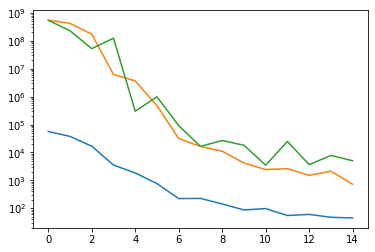

In [111]:
plt.plot(conv_stats[['abs_mean', 'var', 'var_Renyi_Chi']])
plt.yscale('log')

In [110]:
conv_stats

,mean,abs_mean,var,var_Renyi_Chi
0,-56226.324106,56226.324106,5.423749e+08,5.423749e+08
1,37535.749629,37535.749629,4.217815e+08,2.286901e+08
2,16706.288095,16706.288095,1.717058e+08,5.200590e+07
3,3526.307061,3526.307061,6.221630e+06,1.237900e+08
4,1840.319791,1840.319791,3.621295e+06,2.986941e+05
5,765.727468,765.727468,4.735004e+05,9.843835e+05
6,222.248542,222.248542,3.130309e+04,9.134013e+04
7,225.117941,225.117941,1.643613e+04,1.643966e+04
8,142.679953,142.679953,1.101762e+04,2.671068e+04
9,86.741618,86.741618,4.160101e+03,1.802893e+04


# MLMC

In [80]:
def Renyi_Chi_MLMC(loc_beta, scale_beta, gamma, n_MC_out=100, max_level=8, start_level=0):        
    levels = np.arange(start_level, max_level+1)
    weights = 2.**(-3/2*levels)
    weights /= sum(weights)
    Ns = np.zeros_like(levels)
    Ns = np.array([np.math.ceil(w*n_MC_out) for w in weights], dtype=np.int)
    Ns[0] = n_MC_out - sum(Ns[1:])
    
    score = Renyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=Ns[0], n_MC_in=2**start_level)
    for level, n_MC in zip(levels[1:], Ns[1:]):
        score += dRenyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=n_MC, level=level)
    return score

In [88]:
Renyi_Chi(loc, scale, gamma=1/2., n_MC_out=100, n_MC_in=2**8)

<tf.Tensor: shape=(), dtype=float64, numpy=-879.3426918453547>

In [99]:
Renyi_Chi_MLMC(loc, scale, gamma=1/2., n_MC_out=100000, max_level=8, start_level=1)

2
3
4
5
6
7
8


<tf.Tensor: shape=(), dtype=float64, numpy=-763.5578446208564>